# V606 Vul - Period Search in ZTF Data

This notebook addresses the referee's comments on our paper "TESS photometry of the nova eruption in V606 Vul: asymmetric photosphere and multiple ejections?" ([arXiv e-print](https://arxiv.org/abs/2311.04903)) submitted to ApJ. The referee suggested additional analysis of ground-based photometry, which we present here. We have downloaded [ZTF photometry of V606 Vul](v606_vul_ztf_data/v606vul_ztf_photometry.csv) through the [SNAD interface](https://ztf.snad.space/dr23/view/1685207200024460) and extracted pre-eruption r-band data using this simple [shell script](v606_vul_ztf_data/get_ztf_lightcurve_from_snad.sh).

## Pre-eruption ZTF r-band Lightcurve

We start by computing the spectral window (Discrete Fourier Transform of the sampling pattern, where the lightcurve's real magnitude measurements are replaced by a constant value). The spectral window peaks inform us of the periodicities inherent to the data due to the observing times (sampling) - these periodicities are instrumental and characterize the observing strategy rather than any intrinsic property of the observed source. The spectral window is fairly typical for single-site ground-based observations, with the highest peak at a period of 0.997 days corresponding to 1 cycle per sidereal day and multiple harmonics of this period.

We then construct a Lomb-Scargle periodogram of the actual ZTF r-band lightcurve in the trial period range of 0.1 to 100 days. The two highest peaks correspond to periods of 1.035 days and 29.78 days. The second period has an obvious physical interpretation, being close to one synodic month (lunation). One may easily imagine that a slight imperfection in sky background subtraction could leave a trace of that variation in the output lightcurve. The first period is a beat period between the sidereal day (instrumental period revealed by the spectral window) and synodic month (instrumental period likely resulting from sky brightness variations over a lunation). In fact, a pair of peaks corresponding to the sum and difference of the frequencies of these two periods are visible in the periodogram, as well as multiple harmonics of these peaks. Therefore, all peaks standing out in the periodogram can be explained as instrumental effects common to ground-based observations.

Finally, we note that the ZTF r-band lightcurve phased with the 1.035-day period looks surprisingly good for a periodicity that is "not real." First, the Lomb-Scargle periodogram by nature favors trial periods that produce phased lightcurves most similar to sine waves given the available data. Second, magnitude variations over the synodic month are actually present in the data (it's not just a sampling pattern of observations being conducted only at new moon - had this been the case, a 29.5-day peak would be clearly visible in the spectral window - and there is actually excessive power in the spectral window at these low frequencies, but much less than in the daily peaks). The 1.035-day period is simply one possible way to fold these real variations with a much shorter period that is allowed by the sampling pattern.

Reading lightcurve data from v606_vul_ztf_data/v606vul_ztf_r_preeruption.txt
Successfully loaded 172 data points
Observation baseline: 1153.87 days
Baseline frequency resolution: 0.000867 cycles/day
Using 57635 frequency steps for Lomb-Scargle periodogram
Computing spectral window...
Using 57635 frequency steps for spectral window


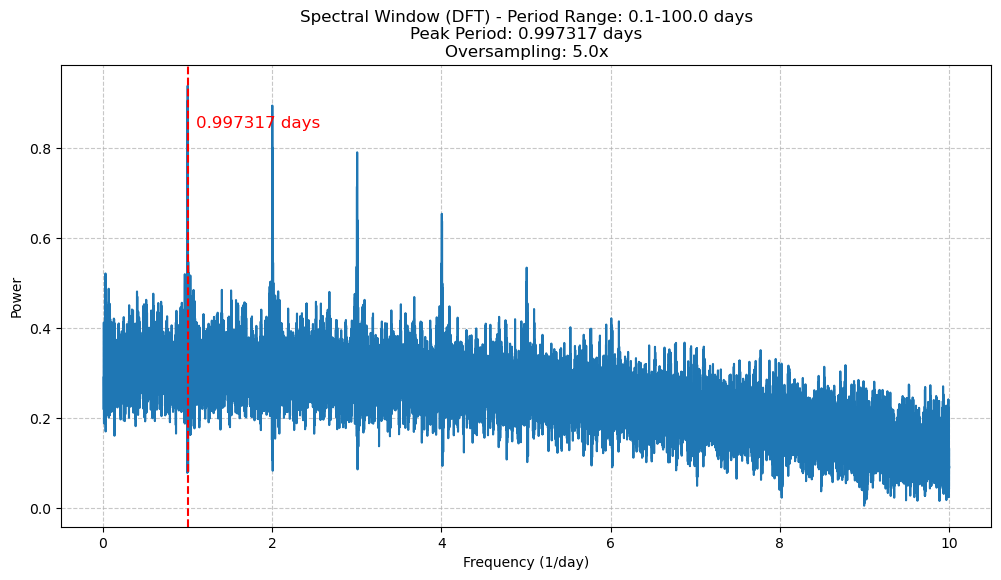

Computing Lomb-Scargle periodogram...


/tmp/ipykernel_2949547/2951789678.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


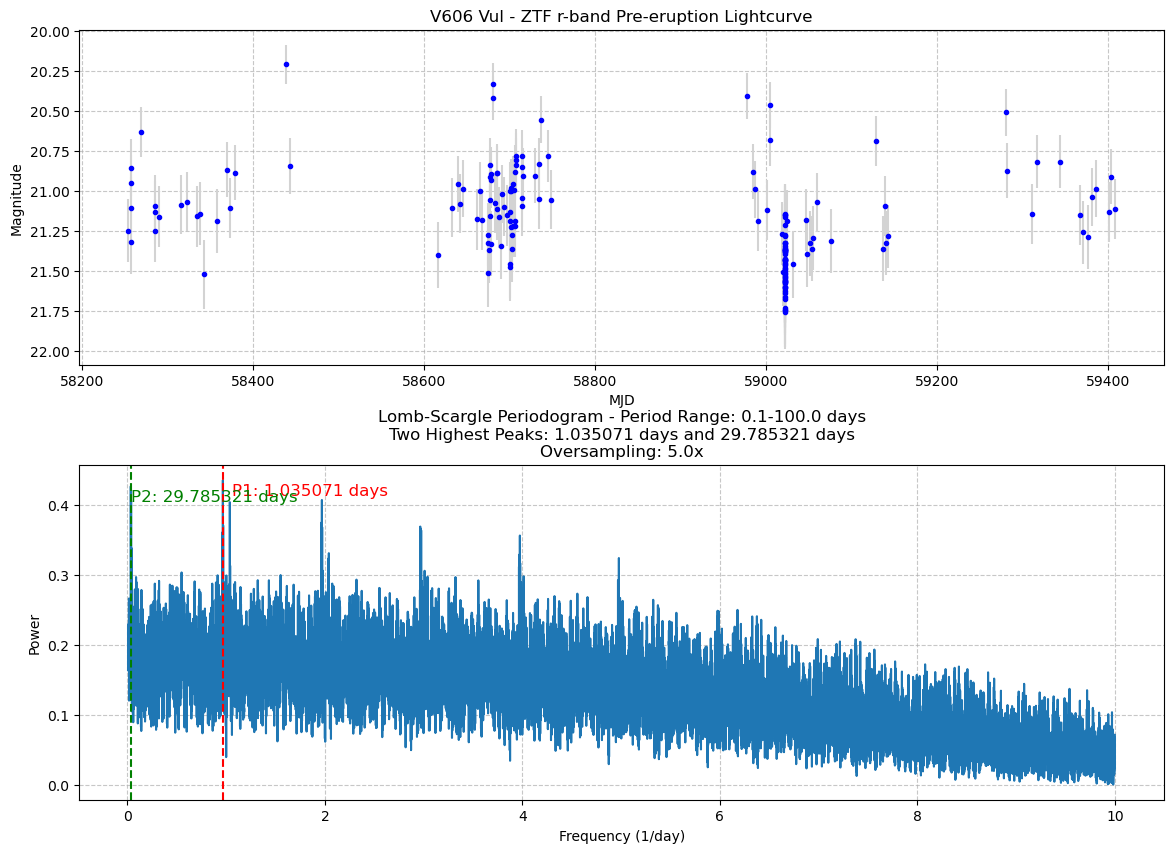

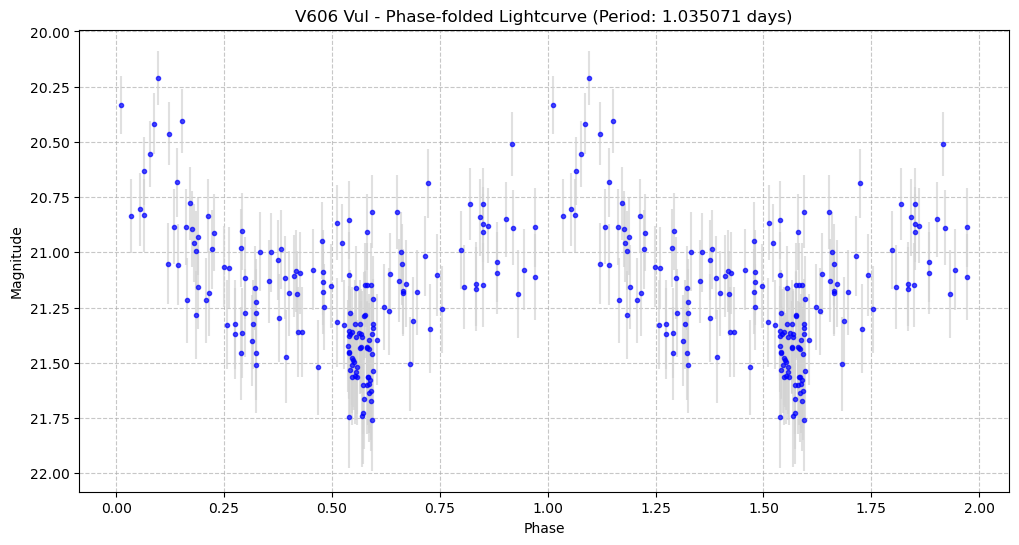


=== SUMMARY OF RESULTS ===
Period Range Analyzed: 0.1-100.0 days
Baseline Duration: 1153.87 days
Frequency Resolution: 0.000867 cycles/day (= 1/baseline)
DFT Oversampling Factor: 5.0x
L-S Oversampling Factor: 5.0x
Spectral Window Peak Period: 0.997317 days
Highest Peak (P1): 1.035071 days
Second Highest Peak (P2): 29.785321 days

=== PERIOD RELATIONSHIP ANALYSIS ===
Predicted Value 1/(1/P_window - 1/P_2): 1.031867 days
Highest Peak (P1): 1.035071 days
Difference between Predicted Value and P1: 0.003204 days
The special value is very close to P1 (< 1% difference).
Relative difference: 0.31%


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from matplotlib.gridspec import GridSpec
%matplotlib inline

# Function for Discrete Fourier Transform (for accurate spectral window computation)
def DFT(freqmin, freqmax, oversample_factor, t, x):
    # Calculate the baseline frequency resolution
    baseline = t.max() - t.min()
    df_baseline = 1.0 / baseline
    
    # Determine number of frequency steps based on oversampling
    nsteps = int(((freqmax - freqmin) / df_baseline) * oversample_factor)
    
    freqvec = np.linspace(freqmin, freqmax, nsteps)
    ampvec = []
    n = float(len(t))
    for freq in freqvec:
        omega = 2. * np.pi * freq
        wts = np.sin(omega * t)
        wtc = np.cos(omega * t)
        camp = np.dot(wtc, x)
        samp = np.dot(wts, x)
        amp = np.sqrt(camp**2 + samp**2)
        ampvec.append(amp)
    
    ampvec = (2./n) * np.array(ampvec)
    imax = np.argmax(ampvec)
    freqmax = freqvec[imax]
    return freqvec, ampvec, freqmax

# Set data and output directory
data_dir = "v606_vul_ztf_data"
# Create directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Set target source name
target_source_name = "V606 Vul"
input_file = os.path.join(data_dir, "v606vul_ztf_r_preeruption.txt")

# Read the lightcurve data from the ASCII file
print(f"Reading lightcurve data from {input_file}")
try:
    data = np.loadtxt(input_file)
    mjd = data[:, 0]  # MJD (Modified Julian Date)
    mag = data[:, 1]  # Magnitude
    mag_err = data[:, 2]  # Magnitude error
    
    # Convert magnitudes to flux (since periodograms usually work better with flux)
    # For magnitude, lower values are brighter, so we need to invert
    flux = 10**(-0.4 * mag)
    # Propagate errors
    flux_err = 0.4 * np.log(10) * flux * mag_err
    
    print(f"Successfully loaded {len(mjd)} data points")
except Exception as e:
    print(f"Error loading file: {e}")
    raise

# Define oversampling factors
oversample_dft = 5.0  # Oversampling factor for spectral window
oversample_ls = 5.0   # Oversampling factor for Lomb-Scargle

# Calculate the baseline frequency resolution
baseline = mjd.max() - mjd.min()
df_baseline = 1.0 / baseline
print(f"Observation baseline: {baseline:.2f} days")
print(f"Baseline frequency resolution: {df_baseline:.6f} cycles/day")

# Define the frequency grid for periodogram with updated period range
min_period, max_period = 0.1, 100.0  # days
min_frequency = 1 / max_period
max_frequency = 1 / min_period

# Calculate number of frequency steps based on oversampling
nsteps_ls = int(((max_frequency - min_frequency) / df_baseline) * oversample_ls)
frequency_grid = np.linspace(min_frequency, max_frequency, nsteps_ls)
print(f"Using {nsteps_ls} frequency steps for Lomb-Scargle periodogram")

# Compute spectral window using DFT
print("Computing spectral window...")
# Create the window function (unit amplitude)
window = np.ones(len(mjd)) * 0.5  # 0.5 for DFT normalization

# Compute spectral window
sw_freq, sw_power, sw_freq_max = DFT(min_frequency, max_frequency, oversample_dft, mjd, window)
best_period_sw = 1.0 / sw_freq_max if sw_freq_max > 0 else 0
print(f"Using {len(sw_freq)} frequency steps for spectral window")

# Plot the spectral window
plt.figure(figsize=(12, 6))
plt.plot(sw_freq, sw_power)
plt.axvline(x=sw_freq_max, color='r', linestyle='--')
plt.text(sw_freq_max*1.1, max(sw_power)*0.9, f"{best_period_sw:.6f} days", 
         color='r', fontsize=12)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Spectral Window (DFT) - Period Range: {min_period}-{max_period} days\nPeak Period: {best_period_sw:.6f} days\nOversampling: {oversample_dft}x")
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(os.path.join(data_dir, "spectral_window.png"), format="png", dpi=300)
plt.show()

# Calculate Lomb-Scargle periodogram for the lightcurve
print("Computing Lomb-Scargle periodogram...")
ls = LombScargle(mjd, flux, flux_err)
power = ls.power(frequency_grid)

# Find the two highest peaks
# Sort the powers in descending order and get indices
sorted_indices = np.argsort(power)[::-1]
best_idx_1 = sorted_indices[0]  # Index of highest peak
best_idx_2 = sorted_indices[1]  # Index of second highest peak

# Get frequencies and periods for the two highest peaks
best_frequency_1 = frequency_grid[best_idx_1]
best_period_1 = 1.0 / best_frequency_1
max_power_1 = power[best_idx_1]

best_frequency_2 = frequency_grid[best_idx_2]
best_period_2 = 1.0 / best_frequency_2
max_power_2 = power[best_idx_2]

# Calculate the special value: 1/(1/P_window - 1/P_2)
f_window = 1.0 / best_period_sw
f_2 = 1.0 / best_period_2
f_special = f_window - f_2
if abs(f_special) > 1e-10:  # Avoid division by very small numbers
    p_special = 1.0 / f_special
else:
    p_special = float('inf')  # If frequencies are too close

# Create a figure with two subplots - lightcurve and periodogram
fig = plt.figure(figsize=(14, 10))
gs = GridSpec(2, 1, height_ratios=[1, 1], hspace=0.3)

# Lightcurve subplot
ax1 = plt.subplot(gs[0])
ax1.errorbar(mjd, mag, yerr=mag_err, fmt='o', markersize=3, color='blue', ecolor='lightgray')
ax1.invert_yaxis()  # Magnitude scale is inverted
ax1.set_xlabel('MJD')
ax1.set_ylabel('Magnitude')
ax1.set_title(f"{target_source_name} - ZTF r-band Pre-eruption Lightcurve")
ax1.grid(True, linestyle='--', alpha=0.7)

# Periodogram subplot
ax2 = plt.subplot(gs[1])
ax2.plot(frequency_grid, power)

# Mark highest peak
ax2.axvline(x=best_frequency_1, color='r', linestyle='--')
ax2.text(best_frequency_1*1.1, max_power_1*0.95, f"P1: {best_period_1:.6f} days", 
         color='r', fontsize=12)

# Mark second highest peak
ax2.axvline(x=best_frequency_2, color='g', linestyle='--')
ax2.text(best_frequency_2*1.1, max_power_2*0.95, f"P2: {best_period_2:.6f} days", 
         color='g', fontsize=12)

ax2.set_xlabel('Frequency (1/day)')
ax2.set_ylabel('Power')
ax2.set_title(f"Lomb-Scargle Periodogram - Period Range: {min_period}-{max_period} days\nTwo Highest Peaks: {best_period_1:.6f} days and {best_period_2:.6f} days\nOversampling: {oversample_ls}x")
ax2.grid(True, linestyle='--', alpha=0.7)

plt.savefig(os.path.join(data_dir, "lightcurve_and_periodogram.png"), format="png", dpi=300)
plt.tight_layout()
plt.show()

# Phase-fold the lightcurve at the best period
phase = (mjd % best_period_1) / best_period_1
# Repeat the data for better visualization
phase_extended = np.concatenate([phase, phase + 1])
mag_extended = np.concatenate([mag, mag])
mag_err_extended = np.concatenate([mag_err, mag_err])

plt.figure(figsize=(12, 6))
plt.errorbar(phase_extended, mag_extended, yerr=mag_err_extended, 
             fmt='o', markersize=3, color='blue', ecolor='lightgray', alpha=0.7)
plt.xlabel('Phase')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()  # Invert y-axis for magnitudes
plt.title(f"{target_source_name} - Phase-folded Lightcurve (Period: {best_period_1:.6f} days)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(os.path.join(data_dir, "phase_folded_lc.png"), format="png", dpi=300)
plt.show()

# Print summary of the results
print("\n=== SUMMARY OF RESULTS ===")
print(f"Period Range Analyzed: {min_period}-{max_period} days")
print(f"Baseline Duration: {baseline:.2f} days")
print(f"Frequency Resolution: {df_baseline:.6f} cycles/day (= 1/baseline)")
print(f"DFT Oversampling Factor: {oversample_dft}x")
print(f"L-S Oversampling Factor: {oversample_ls}x")
print(f"Spectral Window Peak Period: {best_period_sw:.6f} days")
print(f"Highest Peak (P1): {best_period_1:.6f} days")
print(f"Second Highest Peak (P2): {best_period_2:.6f} days")
print("\n=== PERIOD RELATIONSHIP ANALYSIS ===")
print(f"Predicted Value 1/(1/P_window - 1/P_2): {p_special:.6f} days")
print(f"Highest Peak (P1): {best_period_1:.6f} days")
print(f"Difference between Predicted Value and P1: {abs(p_special - best_period_1):.6f} days")
if abs(p_special - best_period_1) / best_period_1 < 0.01:
    print("The special value is very close to P1 (< 1% difference).")
elif abs(p_special - best_period_1) / best_period_1 < 0.05:
    print("The special value is close to P1 (< 5% difference).")
else:
    print("The special value differs significantly from P1.")
print(f"Relative difference: {100 * abs(p_special - best_period_1) / best_period_1:.2f}%")

Now let's repeat the analysis in a narrower range of trial periods: 0.1 to 1.0 days, that would be a reasonable range to search for an orbital period of a nova-hosting binary with a dwarf donor. The spectral window shows the pattern of 1 cycle per siderial day peak and its harmonics. For the Lomb-Scargle periodogram by setting the longest trial period to 1.0 days we have excluded the 1.035 day peak found earlier in the wide range analysis and now the higest peak is at 0.5078 days. Thie value is closer to the beat period between the two-cycles-per-siderial-day peak of the spectral window and siderial 1/(2/0.997234-1/27.3)=0.5079 rather than synodic 1/(2/0.997234-1/29.5)=0.5072 month, but is still likely to be associated with Earth and Moon rather than the nova.



=== ANALYZING NARROWER PERIOD RANGE (0.1-1.0 DAYS) ===

Using 51923 frequency steps for narrow-range Lomb-Scargle periodogram
Computing spectral window for narrow range...
Using 51923 frequency steps for narrow-range spectral window


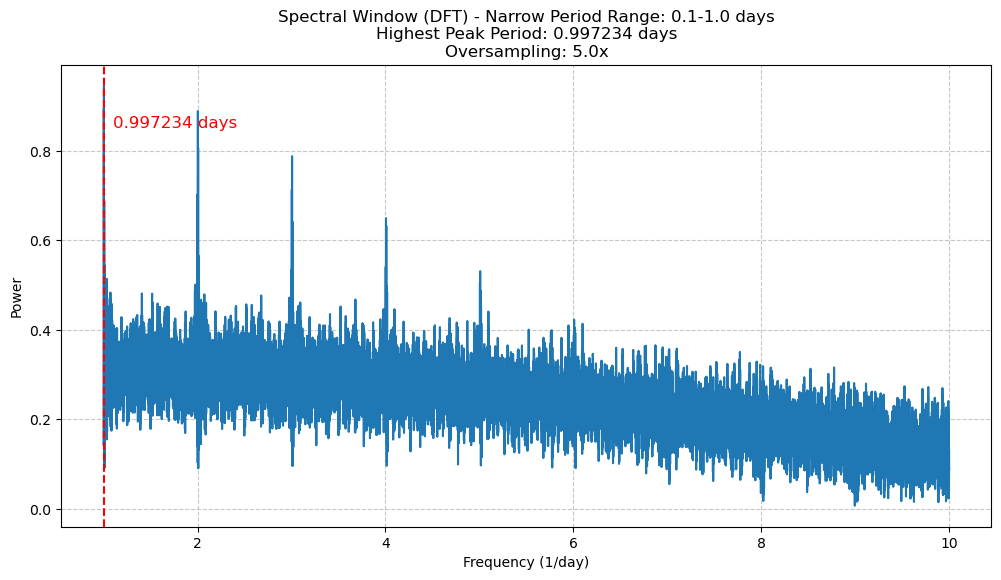

Computing Lomb-Scargle periodogram for narrow range...


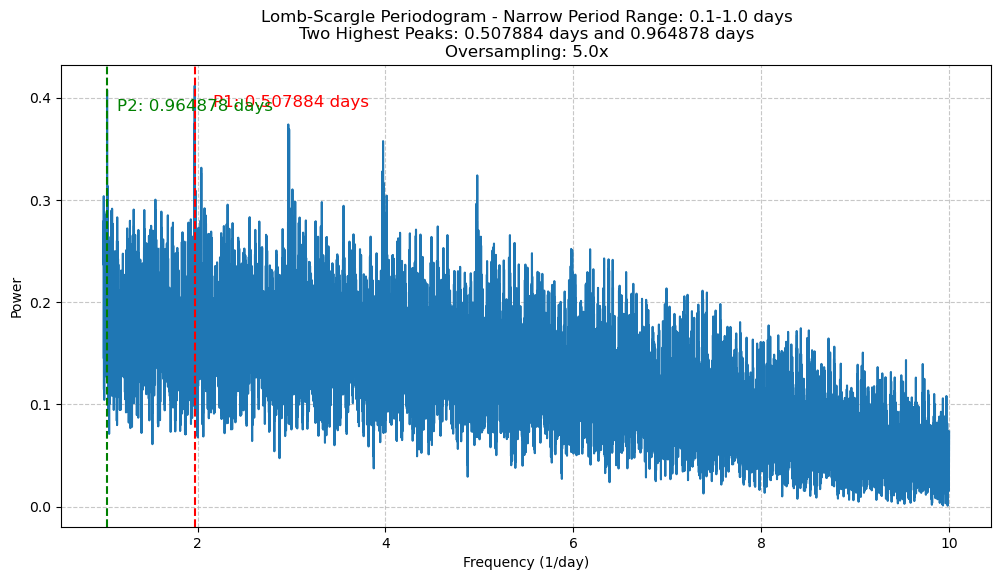

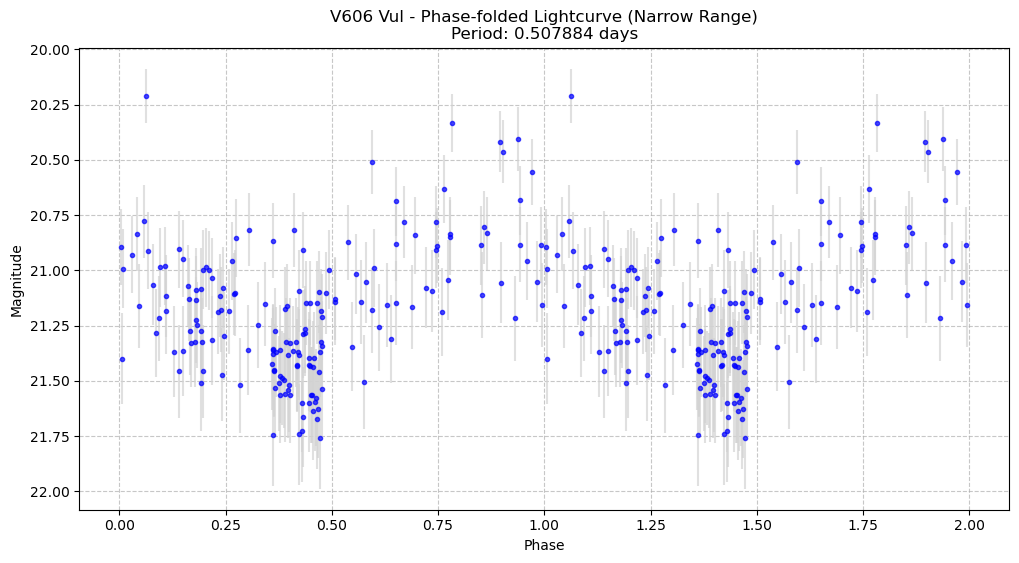


=== SUMMARY OF NARROW RANGE RESULTS ===
Narrow Period Range Analyzed: 0.1-1.0 days
Spectral Window Highest Peak: 0.997234 days
Lomb-Scargle Highest Peak (P1): 0.507884 days
Lomb-Scargle Second Highest Peak (P2): 0.964878 days


In [2]:
# New code block for analyzing a narrower period range (0.1-1.0 days)
print("\n\n=== ANALYZING NARROWER PERIOD RANGE (0.1-1.0 DAYS) ===\n")

# Define narrow period range
min_period_narrow, max_period_narrow = 0.1, 1.0  # days
min_frequency_narrow = 1 / max_period_narrow
max_frequency_narrow = 1 / min_period_narrow

# Calculate number of frequency steps based on same oversampling
nsteps_ls_narrow = int(((max_frequency_narrow - min_frequency_narrow) / df_baseline) * oversample_ls)
frequency_grid_narrow = np.linspace(min_frequency_narrow, max_frequency_narrow, nsteps_ls_narrow)
print(f"Using {nsteps_ls_narrow} frequency steps for narrow-range Lomb-Scargle periodogram")

# Compute spectral window for narrow range
print("Computing spectral window for narrow range...")
sw_freq_narrow, sw_power_narrow, sw_freq_max_narrow = DFT(min_frequency_narrow, max_frequency_narrow, 
                                                        oversample_dft, mjd, window)
best_period_sw_narrow = 1.0 / sw_freq_max_narrow if sw_freq_max_narrow > 0 else 0
print(f"Using {len(sw_freq_narrow)} frequency steps for narrow-range spectral window")

# Plot the narrow-range spectral window
plt.figure(figsize=(12, 6))
plt.plot(sw_freq_narrow, sw_power_narrow)
plt.axvline(x=sw_freq_max_narrow, color='r', linestyle='--')
plt.text(sw_freq_max_narrow*1.1, max(sw_power_narrow)*0.9, f"{best_period_sw_narrow:.6f} days", 
         color='r', fontsize=12)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Spectral Window (DFT) - Narrow Period Range: {min_period_narrow}-{max_period_narrow} days\n"
          f"Highest Peak Period: {best_period_sw_narrow:.6f} days\nOversampling: {oversample_dft}x")
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(os.path.join(data_dir, "spectral_window_narrow.png"), format="png", dpi=300)
plt.show()

# Calculate Lomb-Scargle periodogram for narrow range
print("Computing Lomb-Scargle periodogram for narrow range...")
ls_narrow = LombScargle(mjd, flux, flux_err)
power_narrow = ls_narrow.power(frequency_grid_narrow)

# Find the two highest peaks in the narrow range
sorted_indices_narrow = np.argsort(power_narrow)[::-1]
best_idx_1_narrow = sorted_indices_narrow[0]  # Index of highest peak
best_idx_2_narrow = sorted_indices_narrow[1]  # Index of second highest peak

# Get frequencies and periods for the two highest peaks
best_frequency_1_narrow = frequency_grid_narrow[best_idx_1_narrow]
best_period_1_narrow = 1.0 / best_frequency_1_narrow
max_power_1_narrow = power_narrow[best_idx_1_narrow]

best_frequency_2_narrow = frequency_grid_narrow[best_idx_2_narrow]
best_period_2_narrow = 1.0 / best_frequency_2_narrow
max_power_2_narrow = power_narrow[best_idx_2_narrow]

# Plot the narrow-range periodogram
plt.figure(figsize=(12, 6))
plt.plot(frequency_grid_narrow, power_narrow)

# Mark highest peak
plt.axvline(x=best_frequency_1_narrow, color='r', linestyle='--')
plt.text(best_frequency_1_narrow*1.1, max_power_1_narrow*0.95, f"P1: {best_period_1_narrow:.6f} days", 
         color='r', fontsize=12)

# Mark second highest peak
plt.axvline(x=best_frequency_2_narrow, color='g', linestyle='--')
plt.text(best_frequency_2_narrow*1.1, max_power_2_narrow*0.95, f"P2: {best_period_2_narrow:.6f} days", 
         color='g', fontsize=12)

plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Lomb-Scargle Periodogram - Narrow Period Range: {min_period_narrow}-{max_period_narrow} days\n"
          f"Two Highest Peaks: {best_period_1_narrow:.6f} days and {best_period_2_narrow:.6f} days\n"
          f"Oversampling: {oversample_ls}x")
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(os.path.join(data_dir, "periodogram_narrow.png"), format="png", dpi=300)
plt.show()

# Phase-fold the lightcurve at the best narrow-range period
phase_narrow = (mjd % best_period_1_narrow) / best_period_1_narrow
# Repeat the data for better visualization
phase_extended_narrow = np.concatenate([phase_narrow, phase_narrow + 1])
mag_extended_narrow = np.concatenate([mag, mag])
mag_err_extended_narrow = np.concatenate([mag_err, mag_err])

plt.figure(figsize=(12, 6))
plt.errorbar(phase_extended_narrow, mag_extended_narrow, yerr=mag_err_extended_narrow, 
             fmt='o', markersize=3, color='blue', ecolor='lightgray', alpha=0.7)
plt.xlabel('Phase')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()  # Invert y-axis for magnitudes
plt.title(f"{target_source_name} - Phase-folded Lightcurve (Narrow Range)\nPeriod: {best_period_1_narrow:.6f} days")
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(os.path.join(data_dir, "phase_folded_lc_narrow.png"), format="png", dpi=300)
plt.show()

# Print summary of narrow range results
print("\n=== SUMMARY OF NARROW RANGE RESULTS ===")
print(f"Narrow Period Range Analyzed: {min_period_narrow}-{max_period_narrow} days")
print(f"Spectral Window Highest Peak: {best_period_sw_narrow:.6f} days")
print(f"Lomb-Scargle Highest Peak (P1): {best_period_1_narrow:.6f} days")
print(f"Lomb-Scargle Second Highest Peak (P2): {best_period_2_narrow:.6f} days")

A closer look at the period around one month reveals that periodic signals corresponding to both synodic and sidereal months are present in the data, while the spectral window has multiple peaks in this region and does not allow us to distinguish between the synodic and sidereal month. The presence of two peaks in the Lomb-Scargle periodogram is consistent with the hypothesis that these variations are caused by variable sky brightness. Sky brightness in a particular region would depend not only on the Moon's phase but also on its distance from that sky region.



=== ANALYZING LONGER PERIOD RANGE (20-60 DAYS) WITH HIGHER OVERSAMPLING ===

Using 769 frequency steps for long-range spectral window with 20.0x oversampling
Computing spectral window for long period range...


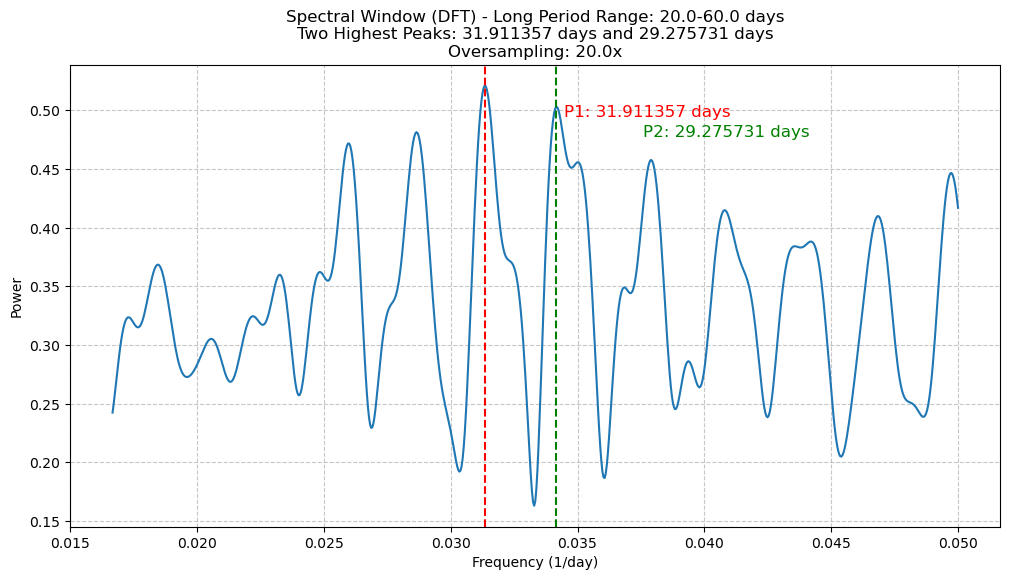

Computing Lomb-Scargle periodogram for long period range...


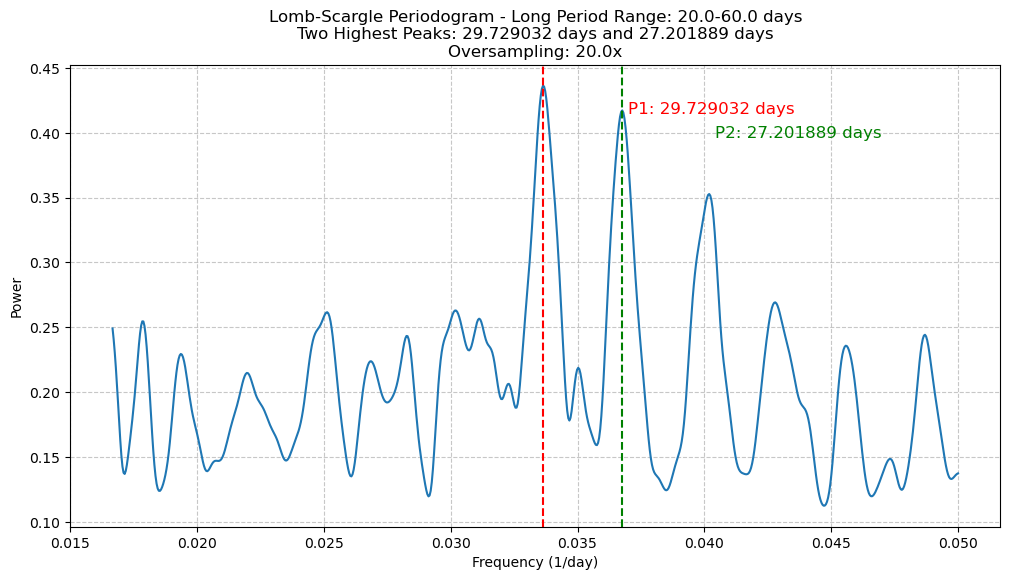

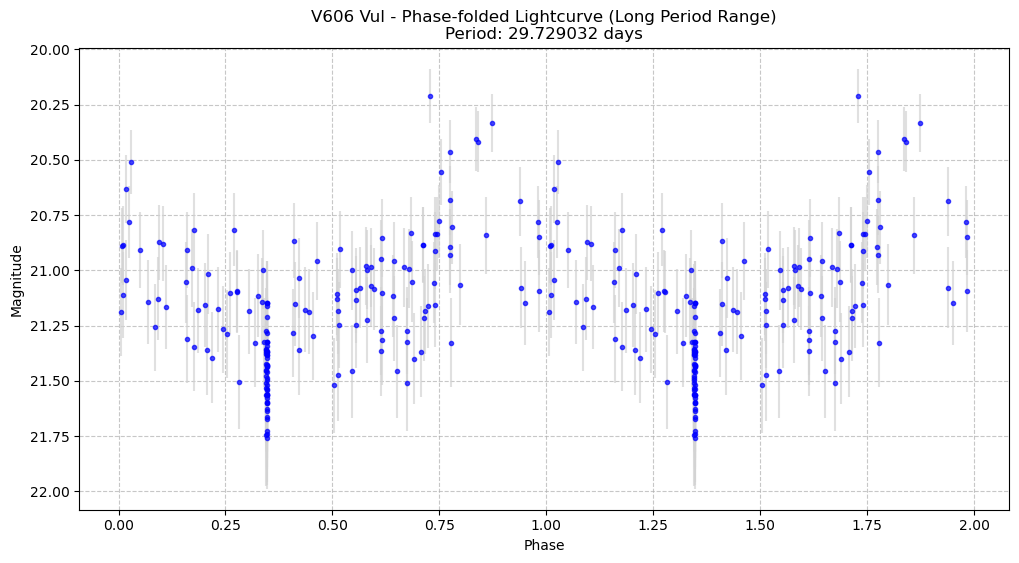


=== SUMMARY OF LONG PERIOD RANGE RESULTS ===
Long Period Range Analyzed: 20.0-60.0 days
Oversampling Factor: 20.0x (increased from 5.0x)
Spectral Window Highest Peak: 31.911357 days
Spectral Window Second Highest Peak: 29.275731 days
Lomb-Scargle Highest Peak: 29.729032 days
Lomb-Scargle Second Highest Peak: 27.201889 days


In [3]:
# New code block for analyzing longer periods (20-60 days) with higher oversampling
print("\n\n=== ANALYZING LONGER PERIOD RANGE (20-60 DAYS) WITH HIGHER OVERSAMPLING ===\n")

# Define longer period range
min_period_long, max_period_long = 20.0, 60.0  # days
min_frequency_long = 1 / max_period_long
max_frequency_long = 1 / min_period_long

# Set higher oversampling factor
oversample_long = 20.0  # Higher oversampling for long period analysis

# Calculate number of frequency steps based on higher oversampling
nsteps_long = int(((max_frequency_long - min_frequency_long) / df_baseline) * oversample_long)
frequency_grid_long = np.linspace(min_frequency_long, max_frequency_long, nsteps_long)
print(f"Using {nsteps_long} frequency steps for long-range spectral window with {oversample_long}x oversampling")

# Compute spectral window for long range
print("Computing spectral window for long period range...")
sw_freq_long, sw_power_long, sw_freq_max_long = DFT(min_frequency_long, max_frequency_long, 
                                                  oversample_long, mjd, window)
best_period_sw_long = 1.0 / sw_freq_max_long if sw_freq_max_long > 0 else 0

# Find the two highest peaks in the spectral window
# Create a copy of power array to find peaks
sw_power_copy = sw_power_long.copy()
# Find highest peak
highest_idx = np.argmax(sw_power_copy)
highest_freq = sw_freq_long[highest_idx]
highest_period = 1.0 / highest_freq
highest_power = sw_power_copy[highest_idx]

# Set the highest peak and surrounding area to zero to find second peak
# Create a mask of points near the first peak (within +/- 5%)
window_size = int(len(sw_freq_long) * 0.05)
mask_start = max(0, highest_idx - window_size)
mask_end = min(len(sw_freq_long), highest_idx + window_size)
sw_power_copy[mask_start:mask_end] = 0

# Find second highest peak
second_idx = np.argmax(sw_power_copy)
second_freq = sw_freq_long[second_idx]
second_period = 1.0 / second_freq
second_power = sw_power_long[second_idx]  # Get original power value

# Plot the long-range spectral window
plt.figure(figsize=(12, 6))
plt.plot(sw_freq_long, sw_power_long)

# Mark highest peak
plt.axvline(x=highest_freq, color='r', linestyle='--')
plt.text(highest_freq*1.1, highest_power*0.95, f"P1: {highest_period:.6f} days", 
         color='r', fontsize=12)

# Mark second highest peak
plt.axvline(x=second_freq, color='g', linestyle='--')
plt.text(second_freq*1.1, second_power*0.95, f"P2: {second_period:.6f} days", 
         color='g', fontsize=12)

plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Spectral Window (DFT) - Long Period Range: {min_period_long}-{max_period_long} days\n"
          f"Two Highest Peaks: {highest_period:.6f} days and {second_period:.6f} days\n"
          f"Oversampling: {oversample_long}x")
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(os.path.join(data_dir, "spectral_window_long.png"), format="png", dpi=300)
plt.show()

# Calculate Lomb-Scargle periodogram for the long range with higher oversampling
print("Computing Lomb-Scargle periodogram for long period range...")
ls_long = LombScargle(mjd, flux, flux_err)
power_long = ls_long.power(frequency_grid_long)

# Find the two highest peaks in the Lomb-Scargle periodogram
# Create a copy of power array to find peaks
ls_power_copy = power_long.copy()
# Find highest peak
ls_highest_idx = np.argmax(ls_power_copy)
ls_highest_freq = frequency_grid_long[ls_highest_idx]
ls_highest_period = 1.0 / ls_highest_freq
ls_highest_power = ls_power_copy[ls_highest_idx]

# Set the highest peak and surrounding area to zero to find second peak
# Create a mask of points near the first peak (within +/- 5%)
ls_window_size = int(len(frequency_grid_long) * 0.05)
ls_mask_start = max(0, ls_highest_idx - ls_window_size)
ls_mask_end = min(len(frequency_grid_long), ls_highest_idx + ls_window_size)
ls_power_copy[ls_mask_start:ls_mask_end] = 0

# Find second highest peak
ls_second_idx = np.argmax(ls_power_copy)
ls_second_freq = frequency_grid_long[ls_second_idx]
ls_second_period = 1.0 / ls_second_freq
ls_second_power = power_long[ls_second_idx]  # Get original power value

# Plot the long-range periodogram
plt.figure(figsize=(12, 6))
plt.plot(frequency_grid_long, power_long)

# Mark highest peak
plt.axvline(x=ls_highest_freq, color='r', linestyle='--')
plt.text(ls_highest_freq*1.1, ls_highest_power*0.95, f"P1: {ls_highest_period:.6f} days", 
         color='r', fontsize=12)

# Mark second highest peak
plt.axvline(x=ls_second_freq, color='g', linestyle='--')
plt.text(ls_second_freq*1.1, ls_second_power*0.95, f"P2: {ls_second_period:.6f} days", 
         color='g', fontsize=12)

plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Lomb-Scargle Periodogram - Long Period Range: {min_period_long}-{max_period_long} days\n"
          f"Two Highest Peaks: {ls_highest_period:.6f} days and {ls_second_period:.6f} days\n"
          f"Oversampling: {oversample_long}x")
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(os.path.join(data_dir, "periodogram_long.png"), format="png", dpi=300)
plt.show()

# Phase-fold the lightcurve at the best long-range period
phase_long = (mjd % ls_highest_period) / ls_highest_period
# Repeat the data for better visualization
phase_extended_long = np.concatenate([phase_long, phase_long + 1])
mag_extended_long = np.concatenate([mag, mag])
mag_err_extended_long = np.concatenate([mag_err, mag_err])

plt.figure(figsize=(12, 6))
plt.errorbar(phase_extended_long, mag_extended_long, yerr=mag_err_extended_long, 
             fmt='o', markersize=3, color='blue', ecolor='lightgray', alpha=0.7)
plt.xlabel('Phase')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()  # Invert y-axis for magnitudes
plt.title(f"{target_source_name} - Phase-folded Lightcurve (Long Period Range)\nPeriod: {ls_highest_period:.6f} days")
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(os.path.join(data_dir, "phase_folded_lc_long.png"), format="png", dpi=300)
plt.show()

# Print summary of long period range results
print("\n=== SUMMARY OF LONG PERIOD RANGE RESULTS ===")
print(f"Long Period Range Analyzed: {min_period_long}-{max_period_long} days")
print(f"Oversampling Factor: {oversample_long}x (increased from {oversample_dft}x)")
print(f"Spectral Window Highest Peak: {highest_period:.6f} days")
print(f"Spectral Window Second Highest Peak: {second_period:.6f} days")
print(f"Lomb-Scargle Highest Peak: {ls_highest_period:.6f} days")
print(f"Lomb-Scargle Second Highest Peak: {ls_second_period:.6f} days")

The variations in ZTF zero-points with lunation were [reported before](http://nesssi.cacr.caltech.edu/ZTF/Web/ZuberPars.html#lunar) as related to sky background variations, but the effect was not fully characterized.